# Idea

Take two sequences with a very high sequence similarity and mutate X into Y and Y into X. Consider the average mutational effect over the entire sequence. Is it the same or is one worde than the other? 

In [4]:
import pandas as pd
import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder, load_gemme_scores_from_folder, load_fasta_file
from tqdm import tqdm

In [2]:
# load the PLA2 dataset 
pla2_fasta_file = '../data/20231031_PLA2.fasta'

pla2_sequences = load_fasta_file(pla2_fasta_file)
pla2_sequences['sequence'] = pla2_sequences['sequence'].astype(str)
pla2_sequences['length'] = pla2_sequences['sequence'].apply(len)
pla2_sequences.head()

,id,sequence,length
0,P00622_caudoxin_Bitis_caudalis,NLIQFGNMISAMTGKSSLAYASYGCYCGWGGKGQPKDDTDRCCFVH...,121
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122


In [3]:
vespag_results = load_vespag_scores_from_folder('/mnt/f/nicole/pla2_vespag/')
vespag_results['vespag'] = -vespag_results['vespag']
vespag_results['mutation_effect'] = (vespag_results['vespag'] - vespag_results['vespag'].min()) / (vespag_results['vespag'].max() - vespag_results['vespag'].min())
vespag_results.head()

Loading VespaG scores: 100%|██████████| 524/524 [00:12<00:00, 42.09file/s]


,residue,mutation,vespag,id,mutation_effect
0,N1,N1A,2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.364656
1,N1,N1Y,3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.493063
2,N1,N1W,4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.530656
3,N1,N1V,3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.471612
4,N1,N1T,2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.343762


In [5]:
gemme_results = load_gemme_scores_from_folder('/mnt/f/nicole/pla2_gemme/')
gemme_results['gemme'] = -gemme_results['gemme']
gemme_results['mutation_effect'] = (gemme_results['gemme'] - gemme_results['gemme'].min()) / (gemme_results['gemme'].max() - gemme_results['gemme'].min())
gemme_results.head()

Loading Gemme scores: 100%|██████████| 524/524 [00:15<00:00, 34.58folder/s]


,residue,mutation,gemme,id,mutation_effect
0,N1,N1A,2.116094,AY355169_1_Sistrurus_tergeminus,0.39324
1,N1,N1V,2.116094,AY355169_1_Sistrurus_tergeminus,0.39324
2,N1,N1T,2.116094,AY355169_1_Sistrurus_tergeminus,0.39324
3,N1,N1S,2.116094,AY355169_1_Sistrurus_tergeminus,0.39324
4,N1,N1R,2.116094,AY355169_1_Sistrurus_tergeminus,0.39324


In [6]:
def get_differing_residues(pla2_sequences, sequence_id):
    """
    Couldn't come up with a better name for a function. 
    
    Determines the sequences that the sequence can mutate into (same length as sequence).
    Determines the (number of) residues that differ between the sequence and the sequences that the sequence can mutate into.
    """
    sequence_length = pla2_sequences[pla2_sequences['id'] == sequence_id]['length'].values[0]
    sequence = pla2_sequences[pla2_sequences['id'] == sequence_id]['sequence'].values[0]
    family_sequences = pla2_sequences[(pla2_sequences['length'] == sequence_length) & (pla2_sequences['id'] != sequence_id)].copy()
    family_sequences['n_different'] = family_sequences.apply(lambda x: sum([1 for i in range(len(x['sequence'])) if x['sequence'][i] != sequence[i]]), axis=1)
    family_sequences['differing_residues'] = family_sequences.apply(lambda x: [i+1 for i in range(len(x['sequence'])) if x['sequence'][i] != sequence[i]], axis=1)
    family_sequences = family_sequences.sort_values('n_different')
    return family_sequences

dfs = []
for idx, row in tqdm(pla2_sequences.iterrows(), total=pla2_sequences.shape[0], desc='Calculating differing residues'):
    try:
        df = get_differing_residues(pla2_sequences, row['id'])
        df['wildtype_id'] = row['id']
        df['wildtype_sequence'] = row['sequence']
        df = df.rename(columns={'id': 'mutant_id', 'sequence': 'mutant_sequence'})
        dfs.append(df[df.n_different <= 10])
    except:
        pass

dfs = pd.concat(dfs)
dfs.head()

Calculating differing residues: 100%|██████████| 524/524 [00:40<00:00, 12.80it/s]


,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...


In [9]:
# above code leads to dublicated pairs, so we need to delete them
dfs['id_pair'] = dfs.apply(lambda row: tuple(sorted([row['wildtype_id'], row['mutant_id']])), axis=1)
print(f'Previously: {dfs.shape[0]}')
dfs = dfs.drop_duplicates(subset=['id_pair']).drop(columns=['id_pair'])
print(f'After: {dfs.shape[0]}')

Previously: 3472
After: 1736


In [10]:
# build the mutations from c atrox to other sequences
def build_mutation(differing_residues, wildtype_sequence, mutant_sequence):
    mutations = []
    inverted_mutation = []
    for r in differing_residues:
        mutations.append(f'{wildtype_sequence[r-1]}{r}{mutant_sequence[r-1]}')
        inverted_mutation.append(f'{mutant_sequence[r-1]}{r}{wildtype_sequence[r-1]}')
    return mutations, inverted_mutation

dfs['mutations'], dfs['inverted_mutations'] = zip(*dfs.apply(lambda x: build_mutation(x['differing_residues'], x['wildtype_sequence'], x['mutant_sequence']), axis=1))
dfs.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[G67S],[S67G]
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T]","[M8L, S40T, S67G, T77N]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T, N99D]","[M8L, S40T, S67G, T77N, D99N]"
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T]","[M8L, S40T, T77N]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 77, 99]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T, N99D]","[M8L, S40T, T77N, D99N]"


In [11]:
tqdm.pandas()

# calculate the mean effect of the mutations to go from c atrox to other sequences and the other way around 
def get_mutation_effects(scores, wildtye_id, mutations, mutant_id, inverted_mutations):
    # find the mutations for the correct sequence
    mutation_effects = list(scores[(scores['mutation'].isin(mutations)) & (scores['id'] == wildtye_id)].mutation_effect.round(4))
    inverted_mutation_effects = list(scores[(scores['mutation'].isin(inverted_mutations)) & (scores['id'] == mutant_id)].mutation_effect.round(4))
    return mutation_effects, inverted_mutation_effects

dfs['vespag_mutation_effects'], dfs['vespag_inverted_mutation_effects'] = zip(*dfs.progress_apply(
    lambda x: get_mutation_effects(vespag_results, x['wildtype_id'], x['mutations'], x['mutant_id'], x['inverted_mutations']),
    axis=1
))
dfs.head()

100%|██████████| 1736/1736 [05:43<00:00,  5.05it/s]


,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,vespag_mutation_effects,vespag_inverted_mutation_effects
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[G67S],[S67G],[0.1379],[0.3423]
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T]","[M8L, S40T, S67G, T77N]","[0.2869, 0.4013, 0.1379, 0.2501]","[0.3123, 0.2664, 0.3487, 0.2524]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T, N99D]","[M8L, S40T, S67G, T77N, D99N]","[0.2869, 0.4013, 0.1379, 0.2501, 0.3966]","[0.3152, 0.2673, 0.3509, 0.2562, 0.2385]"
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T]","[M8L, S40T, T77N]","[0.2855, 0.3981, 0.2474]","[0.3123, 0.2664, 0.2524]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 77, 99]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T, N99D]","[M8L, S40T, T77N, D99N]","[0.2855, 0.3981, 0.2474, 0.3988]","[0.3152, 0.2673, 0.2562, 0.2385]"


In [12]:
dfs['gemme_mutation_effects'], dfs['gemme_inverted_mutation_effects'] = zip(*dfs.progress_apply(
    lambda x: get_mutation_effects(gemme_results, x['wildtype_id'], x['mutations'], x['mutant_id'], x['inverted_mutations']),
    axis=1
))
dfs.head()

100%|██████████| 1736/1736 [04:48<00:00,  6.01it/s]


,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,vespag_mutation_effects,vespag_inverted_mutation_effects,gemme_mutation_effects,gemme_inverted_mutation_effects
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[G67S],[S67G],[0.1379],[0.3423],[0.1864],[0.3422]
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T]","[M8L, S40T, S67G, T77N]","[0.2869, 0.4013, 0.1379, 0.2501]","[0.3123, 0.2664, 0.3487, 0.2524]","[0.2821, 0.3253, 0.1864, 0.3238]","[0.3293, 0.256, 0.3485, 0.2582]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T, N99D]","[M8L, S40T, S67G, T77N, D99N]","[0.2869, 0.4013, 0.1379, 0.2501, 0.3966]","[0.3152, 0.2673, 0.3509, 0.2562, 0.2385]","[0.2821, 0.3253, 0.1864, 0.3238, 0.3201]","[0.3384, 0.2638, 0.3375, 0.268, 0.2479]"
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T]","[M8L, S40T, T77N]","[0.2855, 0.3981, 0.2474]","[0.3123, 0.2664, 0.2524]","[0.2774, 0.3191, 0.3062]","[0.3293, 0.256, 0.2582]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 77, 99]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T, N99D]","[M8L, S40T, T77N, D99N]","[0.2855, 0.3981, 0.2474, 0.3988]","[0.3152, 0.2673, 0.2562, 0.2385]","[0.2774, 0.3191, 0.3062, 0.3779]","[0.3384, 0.2638, 0.268, 0.2479]"


In [13]:
dfs['vespag_mean_mutation_effect'] = dfs['vespag_mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
dfs['vespag_mean_inverted_mutation_effect'] = dfs['vespag_inverted_mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
dfs['gemme_mean_mutation_effect'] = dfs['gemme_mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
dfs['gemme_mean_inverted_mutation_effect'] = dfs['gemme_inverted_mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
dfs.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,vespag_mutation_effects,vespag_inverted_mutation_effects,gemme_mutation_effects,gemme_inverted_mutation_effects,vespag_mean_mutation_effect,vespag_mean_inverted_mutation_effect,gemme_mean_mutation_effect,gemme_mean_inverted_mutation_effect
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[G67S],[S67G],[0.1379],[0.3423],[0.1864],[0.3422],0.137900,0.342300,0.18640,0.342200
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T]","[M8L, S40T, S67G, T77N]","[0.2869, 0.4013, 0.1379, 0.2501]","[0.3123, 0.2664, 0.3487, 0.2524]","[0.2821, 0.3253, 0.1864, 0.3238]","[0.3293, 0.256, 0.3485, 0.2582]",0.269050,0.294950,0.27940,0.298000
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T, N99D]","[M8L, S40T, S67G, T77N, D99N]","[0.2869, 0.4013, 0.1379, 0.2501, 0.3966]","[0.3152, 0.2673, 0.3509, 0.2562, 0.2385]","[0.2821, 0.3253, 0.1864, 0.3238, 0.3201]","[0.3384, 0.2638, 0.3375, 0.268, 0.2479]",0.294560,0.285620,0.28754,0.291120
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T]","[M8L, S40T, T77N]","[0.2855, 0.3981, 0.2474]","[0.3123, 0.2664, 0.2524]","[0.2774, 0.3191, 0.3062]","[0.3293, 0.256, 0.2582]",0.310333,0.277033,0.30090,0.281167
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 77, 99]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T, N99D]","[M8L, S40T, T77N, D99N]","[0.2855, 0.3981, 0.2474, 0.3988]","[0.3152, 0.2673, 0.2562, 0.2385]","[0.2774, 0.3191, 0.3062, 0.3779]","[0.3384, 0.2638, 0.268, 0.2479]",0.332450,0.269300,0.32015,0.279525


In [14]:
dfs['vespag_diff_mean'] = (dfs['vespag_mean_mutation_effect'] - dfs['vespag_mean_inverted_mutation_effect']).abs()
dfs['gemme_diff_mean'] = (dfs['gemme_mean_mutation_effect'] - dfs['gemme_mean_inverted_mutation_effect']).abs()
dfs = dfs.sort_values('vespag_diff_mean', ascending=False)
dfs.to_csv('summary_symmetrical_mutations.csv', index=False, sep='\t')

## Start from here to avoid runtime above

In [15]:
# dfs = pd.read_csv('summary_symmetrical_mutations.csv', sep='\t')
# dfs.head()

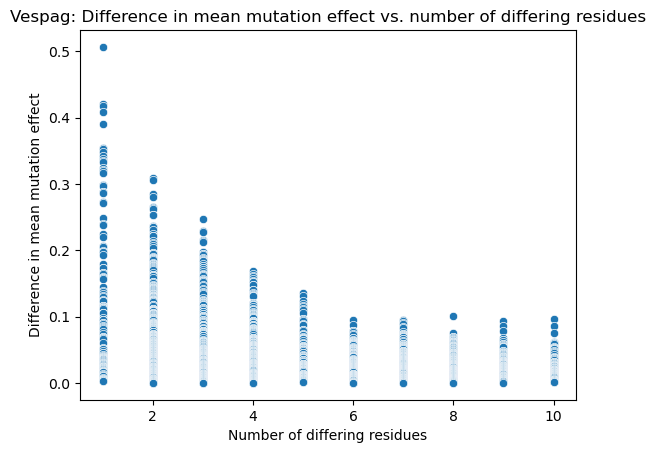

In [18]:
# plot the number of differing residues against the diff_mean
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.scatterplot(data=dfs, x='n_different', y='vespag_diff_mean', color='tab:blue')
plt.title('Vespag: Difference in mean mutation effect vs. number of differing residues')
plt.xlabel('Number of differing residues')
plt.ylabel('Difference in mean mutation effect')
plt.show()

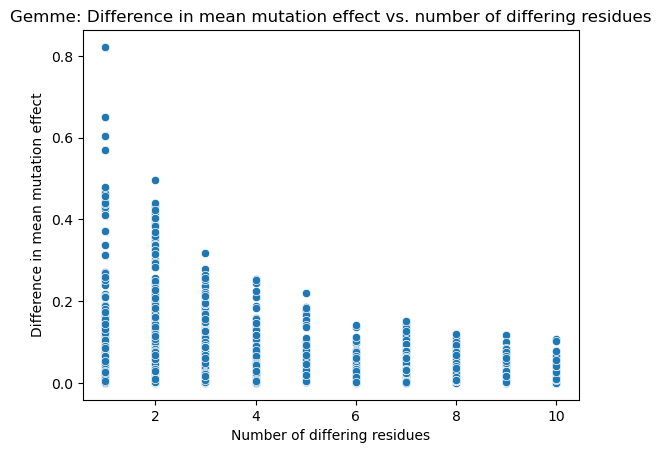

In [19]:
sns.scatterplot(data=dfs, x='n_different', y='gemme_diff_mean', color='tab:blue')
plt.title('Gemme: Difference in mean mutation effect vs. number of differing residues')
plt.xlabel('Number of differing residues')
plt.ylabel('Difference in mean mutation effect')
plt.show()

In [21]:
dfs.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,vespag_mutation_effects,vespag_inverted_mutation_effects,gemme_mutation_effects,gemme_inverted_mutation_effects,vespag_mean_mutation_effect,vespag_mean_inverted_mutation_effect,gemme_mean_mutation_effect,gemme_mean_inverted_mutation_effect,vespag_diff_mean,gemme_diff_mean
168,EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,121,1,[28],GDAZ01000058_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNFGWGHRGQPKDATDRCCFV...,[F28C],[C28F],[0.2565],[0.7629],[0.0051],[0.8273],0.2565,0.7629,0.0051,0.8273,0.5064,0.8222
424,AJ580267_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKDATDRCCFV...,122,1,[38],AJ580271_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKGATDRCCFV...,[G38D],[D38G],[0.2873],[0.7072],[0.0562],[0.6265],0.2873,0.7072,0.0562,0.6265,0.4199,0.5703
63,AJ580210_1_Vipera_aspis_aspis,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,121,1,[92],AJ580213_1_Vipera_ammodytes_ruffoi,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,[E92A],[A92E],[0.2177],[0.6357],[0.0797],[0.7312],0.2177,0.6357,0.0797,0.7312,0.4180,0.6515
168,EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,121,1,[100],GDAZ01000057_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,[P100L],[L100P],[0.1584],[0.5673],[0.2079],[0.3975],0.1584,0.5673,0.2079,0.3975,0.4089,0.1896
447,GR950539_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGCFCGGGDKGKPKDATDRCCFVH...,121,1,[25],GR951187_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGRFCGGGDKGKPKDATDRCCFVH...,[R25C],[C25R],[0.2857],[0.6752],[0.1166],[0.5948],0.2857,0.6752,0.1166,0.5948,0.3895,0.4782


In [25]:
threshold = 0.3
large_differing_mutations = dfs[dfs.vespag_diff_mean > threshold].copy()
# import ast
# large_differing_mutations['relatives'] = large_differing_mutations.apply(
#     lambda row: f"{row['wildtype_id']} - {row['mutant_id']} ({', '.join(ast.literal_eval(row['mutations']))})",
#     axis=1
# )
large_differing_mutations['relatives'] = large_differing_mutations.apply(
    lambda row: f"{row['wildtype_id']} - {row['mutant_id']} ({', '.join(row['mutations'])})",
    axis=1
)
large_differing_mutations.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,vespag_mutation_effects,vespag_inverted_mutation_effects,gemme_mutation_effects,gemme_inverted_mutation_effects,vespag_mean_mutation_effect,vespag_mean_inverted_mutation_effect,gemme_mean_mutation_effect,gemme_mean_inverted_mutation_effect,vespag_diff_mean,gemme_diff_mean,relatives
168,EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,121,1,[28],GDAZ01000058_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNFGWGHRGQPKDATDRCCFV...,[F28C],[C28F],[0.2565],[0.7629],[0.0051],[0.8273],0.2565,0.7629,0.0051,0.8273,0.5064,0.8222,GDAZ01000058_1_Agkistrodon_piscivorus - EV8548...
424,AJ580267_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKDATDRCCFV...,122,1,[38],AJ580271_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKGATDRCCFV...,[G38D],[D38G],[0.2873],[0.7072],[0.0562],[0.6265],0.2873,0.7072,0.0562,0.6265,0.4199,0.5703,AJ580271_1_Vipera_ammodytes_montandoni - AJ580...
63,AJ580210_1_Vipera_aspis_aspis,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,121,1,[92],AJ580213_1_Vipera_ammodytes_ruffoi,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,[E92A],[A92E],[0.2177],[0.6357],[0.0797],[0.7312],0.2177,0.6357,0.0797,0.7312,0.4180,0.6515,AJ580213_1_Vipera_ammodytes_ruffoi - AJ580210_...
168,EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,121,1,[100],GDAZ01000057_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,[P100L],[L100P],[0.1584],[0.5673],[0.2079],[0.3975],0.1584,0.5673,0.2079,0.3975,0.4089,0.1896,GDAZ01000057_1_Agkistrodon_piscivorus - EV8548...
447,GR950539_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGCFCGGGDKGKPKDATDRCCFVH...,121,1,[25],GR951187_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGRFCGGGDKGKPKDATDRCCFVH...,[R25C],[C25R],[0.2857],[0.6752],[0.1166],[0.5948],0.2857,0.6752,0.1166,0.5948,0.3895,0.4782,GR951187_1_Echis_pyramidum_leakeyi - GR950539_...


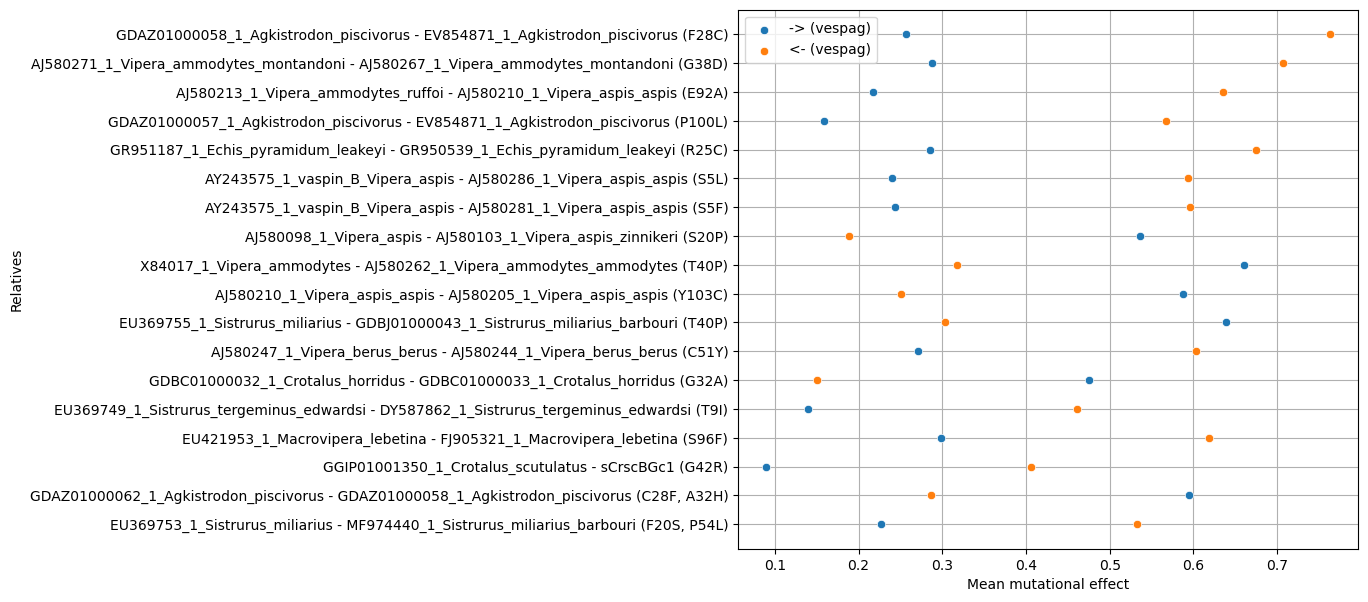

In [31]:
# scatterplot of these mean effects
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 7))
sns.scatterplot(y='relatives', x='vespag_mean_mutation_effect', data=large_differing_mutations, label='-> (vespag)', zorder=2)
sns.scatterplot(y='relatives', x='vespag_mean_inverted_mutation_effect', data=large_differing_mutations, label='<- (vespag)', zorder=2)
plt.xlabel('Mean mutational effect')
plt.ylabel('Relatives')
plt.legend()
plt.grid(zorder=0)
plt.show()

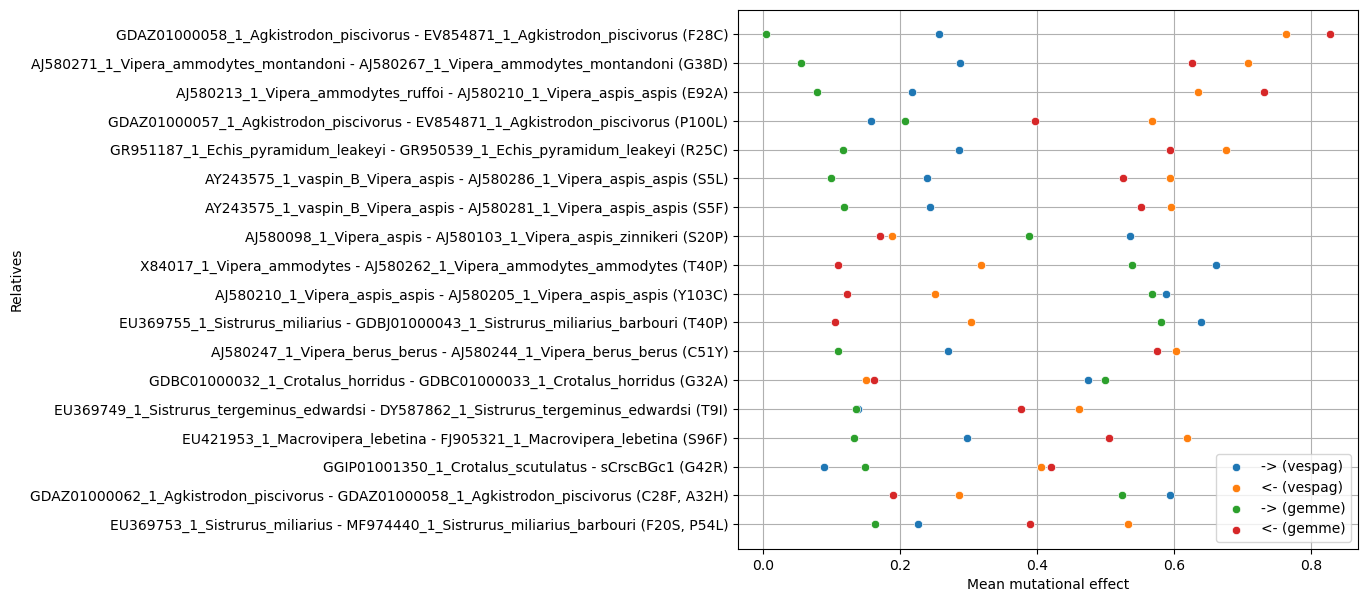

In [32]:
plt.figure(figsize=(8, 7))
sns.scatterplot(y='relatives', x='vespag_mean_mutation_effect', data=large_differing_mutations, label='-> (vespag)', zorder=2)
sns.scatterplot(y='relatives', x='vespag_mean_inverted_mutation_effect', data=large_differing_mutations, label='<- (vespag)', zorder=2)
sns.scatterplot(y='relatives', x='gemme_mean_mutation_effect', data=large_differing_mutations, label='-> (gemme)', zorder=2)
sns.scatterplot(y='relatives', x='gemme_mean_inverted_mutation_effect', data=large_differing_mutations, label='<- (gemme)', zorder=2)
plt.xlabel('Mean mutational effect')
plt.ylabel('Relatives')
plt.legend()
plt.grid(zorder=0)
plt.show()

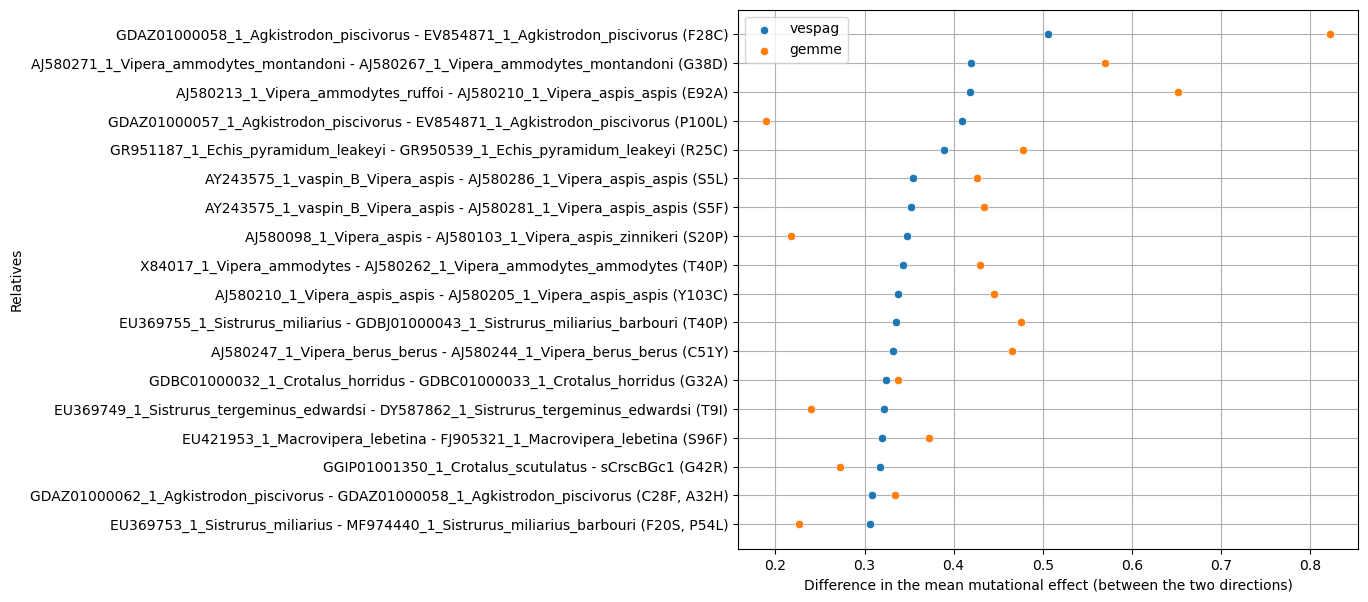

In [36]:
plt.figure(figsize=(8, 7))
sns.scatterplot(y='relatives', x='vespag_diff_mean', data=large_differing_mutations, label='vespag', zorder=2)
sns.scatterplot(y='relatives', x='gemme_diff_mean', data=large_differing_mutations, label='gemme', zorder=2)
plt.xlabel('Difference in the mean mutational effect (between the two directions)')
plt.ylabel('Relatives')
plt.legend()
plt.grid(zorder=0)
plt.show()